# Data Transformation

## Evolution of `torch.transforms`

The transforms available in PyTorch were significantly updated in 2023. The most significant updates include the move to a newer `v2` version of the transforms module, and the deprecation of the commonly used `ToTensor()` transform, which converts data to a PyTorch tensor representation.

You can read more about the move to `v2` of `torch.transforms` [here](https://pytorch.org/vision/stable/generated/torchvision.transforms.v2.ToTensor.html#torchvision.transforms.v2.ToTensor) and the deprecation of `ToTensor()` [here](https://pytorch.org/vision/stable/generated/torchvision.transforms.v2.ToTensor.html#torchvision.transforms.v2.ToTensor).

Instead of `ToTensor()`, PyTorch now requests users do the following composition.

```python
v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
```

Like many constructs in PyTorch, we can use transforms as classes or functions. The difference is mostly stylistic but some functional variations of transforms might have different parameters from their class counterparts.

## Setup

We start by importing `torch`, `torchvision.datasets`, and `torchvision.transforms.v2`.

In [1]:
import torch

# Data loading
from torchvision import datasets

# PyTorch recommends using v2 now
# https://pytorch.org/vision/stable/transforms.html
from torchvision.transforms import v2

# Visualization
import matplotlib.pyplot as plt

# Seed and device configuration
torch.manual_seed(1)

## First Look at Transforms

As a first look, we compose some basic built in transforms with some custom transforms. Composing transforms enables us to define a single transform $f$ which applies a series of other transforms one after the other, $f(x) = f_N( \cdots f_2(f_1(x)))$. Performing transforms and composition of transforms in PyTorch enables us to develop data pipelines far more efficiently than implementing transforms and their composition from scratch. Using PyTorch's implementation also enables us to apply the transforms to our data in various ways during the training process by providing the transforms to the datasets and data loaders we instantiate. This is useful for tasks such as applying random rotations to our data to ensure our models learn rotation invariant features.

In [2]:
class GrayscaleToRGB:
    def __call__(self, image):
        if image.mode == "L":
            image = image.convert("RGB")
        return image


transform = v2.Compose(
    [
        v2.Resize((224, 224)),
        GrayscaleToRGB(),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
    ]
)

dataset = datasets.Caltech101(
    root="example_data", download=True, transform=transform
)

Files already downloaded and verified


We took several steps here.

* First, we defined a custom transform by writing a class which implements the `__call__` method. This transform converts an image to RGB if the image is not RGB already. This is helpful since some images in the dataset are grayscale and some are RGB. The grayscale images or of dimension $1\times N \times M$ while the RGB images are of dimension $3 \times N \times M$. It is helpful to have all images be of the same dimensions so we can process them the same way.
* Next, we used `v2.Compose` to create a pipeline of transforms to apply to the data. The particular pipeline we instantiated resizes the images to a common size, converts them to RGB, and then uses the recommended process for `v2` to convert them to a tensor to be processed by PyTorch.
* Finally, with our pipeline defined, we pass our transform to the dataset constructor to be applied to each image.

## Visualizing our Transforms

We can visualize our transforms by iterating through the dataset and allowing the methods inherited from the `Dataset` class perform the transforms for us from here on out. We do not need to write additional lines of code to apply our transforms. We'll use a quick utility function throughout to load groups of images so we can see them.

In [3]:
def show_images(dataset):
    figure = plt.figure(figsize=(8, 8))
    columns, rows = 5, 5
    for index in range(1, columns * rows + 1):
        sample_index = torch.randint(len(dataset), size=(1,)).item()
        image, label = dataset[sample_index]
        figure.add_subplot(rows, columns, index)
        plt.axis("off")
        plt.imshow(image.permute(1, 2, 0).squeeze(), cmap="gray")
        plt.title("Class Index = {}".format(label))
        plt.tight_layout()
    plt.show()

The function displays a random selection of 25 images.

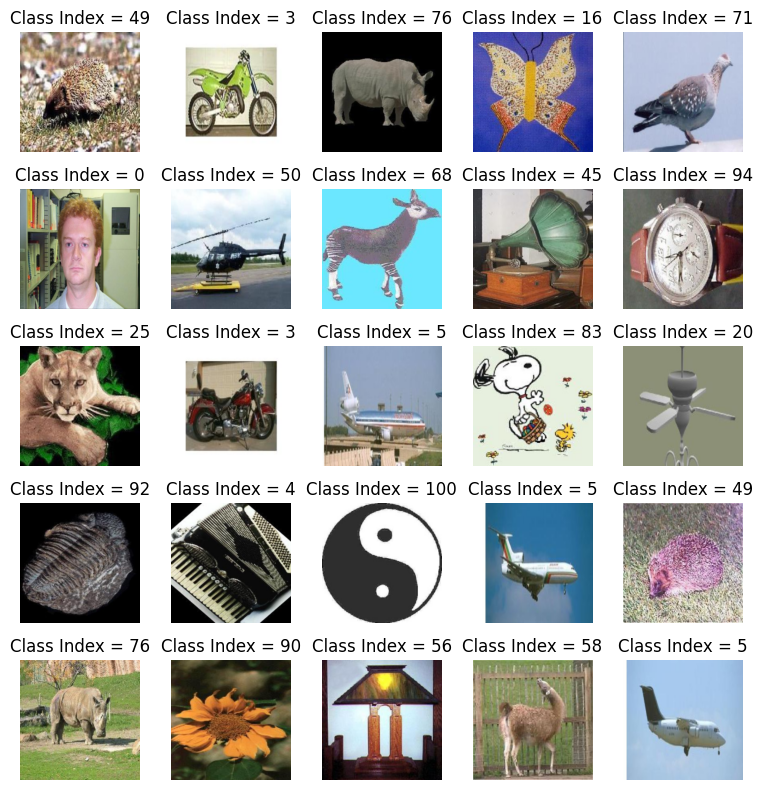

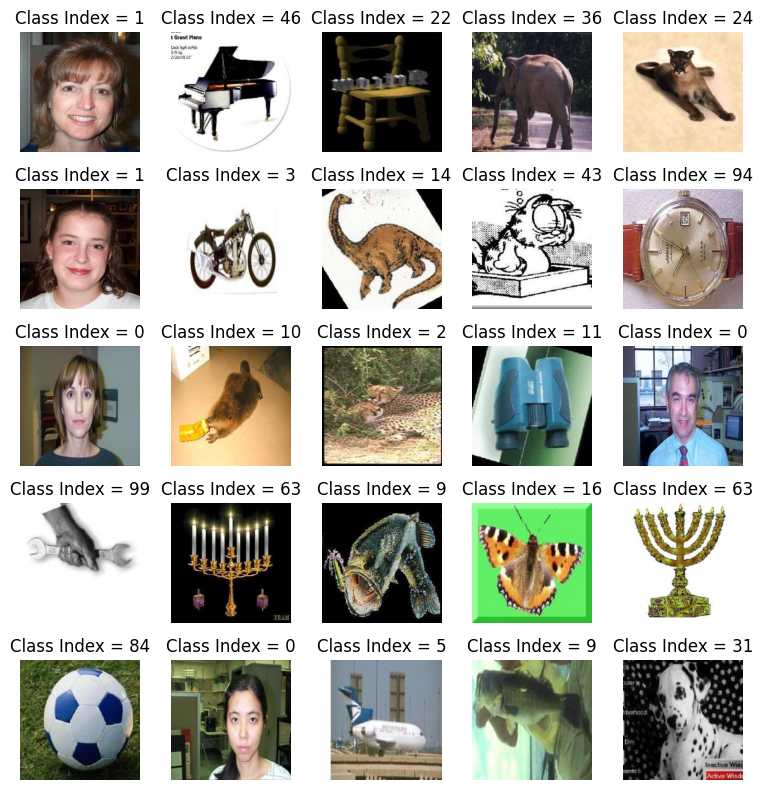

In [4]:
show_images(dataset)
show_images(dataset)
show_images(dataset)

We can reset the seed to see the same images again.

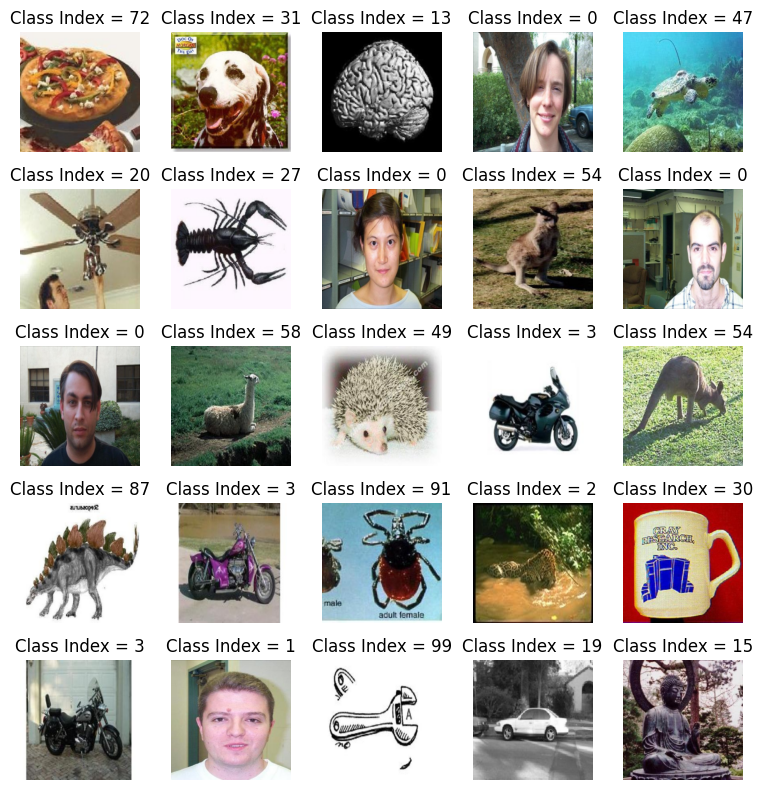

In [5]:
torch.manual_seed(1)
show_images(dataset)

## Additional Examples

Torch provides many, many transforms. You can see the full list [here](https://pytorch.org/vision/stable/transforms.html).

We'll apply a few to our dataset below.

### Grayscale

In [6]:
transform = v2.Compose(
    [
        v2.Resize((224, 224)),
        v2.Grayscale(),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
    ]
)

dataset = datasets.Caltech101(
    root="example_data", download=True, transform=transform
)

torch.manual_seed(1)
show_images(dataset)

Files already downloaded and verified


## Random Affine Transformation and Perspective Change

Files already downloaded and verified


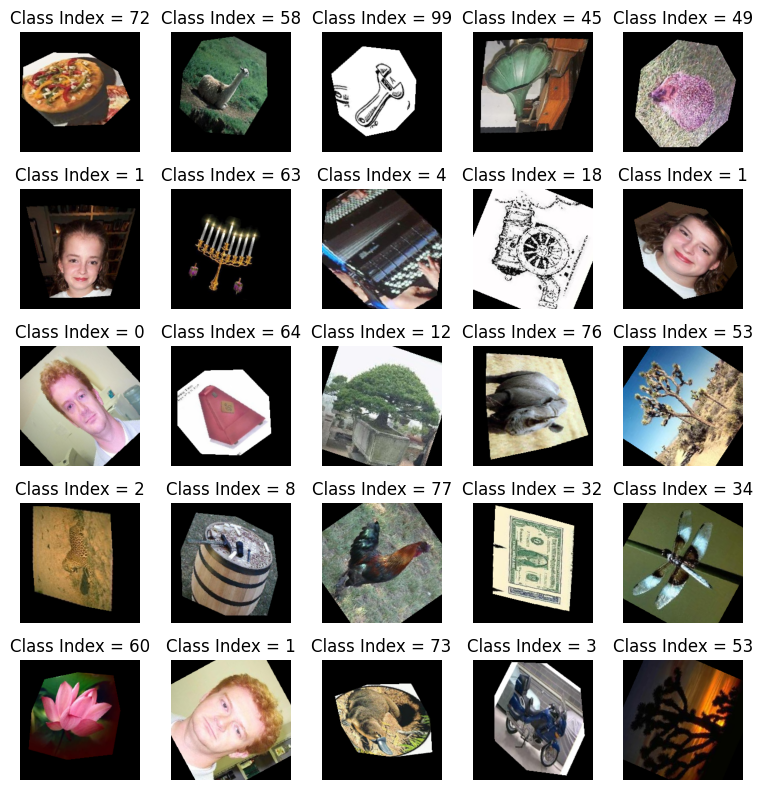

In [9]:
transform = v2.Compose(
    [
        v2.Resize((224, 224)),
        v2.RandomAffine(degrees=90),
        v2.RandomPerspective(),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
    ]
)

dataset = datasets.Caltech101(
    root="example_data", download=True, transform=transform
)

show_images(dataset)

## Color Jitter

In [14]:
transform = v2.Compose(
    [
        v2.Resize((224, 224)),
        v2.ColorJitter(brightness=1, contrast=1, saturation=1, hue=0.5),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
    ]
)

dataset = datasets.Caltech101(
    root="example_data", download=True, transform=transform
)

torch.manual_seed(1)
show_images(dataset)

Files already downloaded and verified


## Blur and Sharpness

Files already downloaded and verified


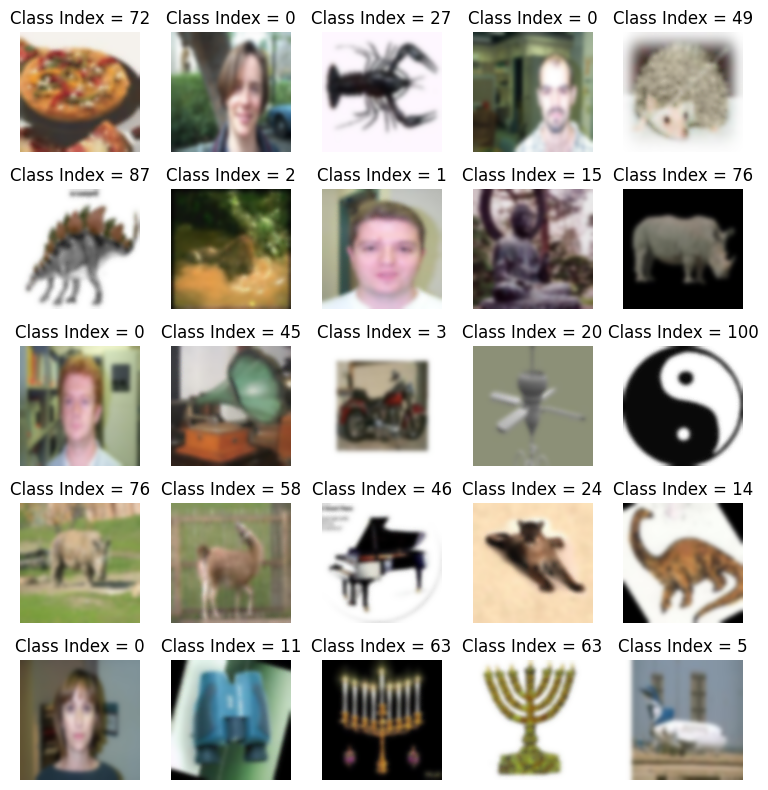

In [23]:
transform = v2.Compose(
    [
        v2.Resize((224, 224)),
        v2.GaussianBlur(101, sigma=4),
        v2.RandomAdjustSharpness(10),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
    ]
)

dataset = datasets.Caltech101(
    root="example_data", download=True, transform=transform
)

torch.manual_seed(1)
show_images(dataset)

## Discussion: Use of Transforms in Robust ML Practice

Data transform pipelines are critical in both training and testing stages to ensure models will be ready for deployment.

* Data augmentation
* Ensuring robustness to variability in the environment (e.g., blur)
* Quantifying performance against challenging factors (blur, color change, perspective shift)
* Explicitly ensuring an algorithm learns to ignore a particular data attribute by densely representing that attribute across all classes in the training set.

## Further Reading

PyTorch provides many state of the art data transformations from recent literature. You can read about a few of them in the papers below.

* **SSD: Single Shot MultiBox Detector (Liu et al.)**: [https://arxiv.org/abs/1512.02325](https://arxiv.org/abs/1512.02325).
* **Simple Copy-Paste is a Strong Data Augmentation Method for Instance Segmentation (Ghiasi et al.)**: [https://arxiv.org/abs/2012.07177](https://arxiv.org/abs/2012.07177).
* **AugMix: A Simple Data Processing Method to Improve Robustness and Uncertainty (Hendrycks et al.)**: [https://arxiv.org/abs/1912.02781](https://arxiv.org/abs/1912.02781)
* **TrivialAugment: Tuning-free Yet State-of-the-Art Data Augmentation (Muller and Hutter)**: [https://arxiv.org/abs/2103.10158](https://arxiv.org/abs/2103.10158)
* **RandAugment: Practical automated data augmentation with a reduced search space (Cubuk)**: [https://arxiv.org/abs/1909.13719](https://arxiv.org/abs/1909.13719)
* **AutoAugment: Learning Augmentation Strategies from Data (Cubuk)**: [https://arxiv.org/pdf/1805.09501](https://arxiv.org/pdf/1805.09501)